In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [110]:
df = pd.read_csv('hospitalizaciones_train.csv')
df['Stay'] = 0
df.loc[df['Stay (in days)'] > 8, 'Stay'] = 1

In [66]:
le = preprocessing.LabelEncoder()
enc = preprocessing.OneHotEncoder(sparse=False)

In [111]:
generos = df.gender.values.reshape(-1,1)
enc.fit(generos)
generos = enc.transform(generos)
print(generos)
df['female'] = generos[:,0]
df['male'] = generos[:,1]
df['other'] = generos[:,2]

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [112]:
departamento = df.Department.values.reshape(-1,1)
enc.fit(departamento)
departamento = enc.transform(departamento)
df['TB & Chest disease'] = departamento[:,0]
df['anesthesia'] = departamento[:,1]
df['gynecology'] = departamento[:,2]
df['radiotherapy'] = departamento[:,3]
df['surgery'] = departamento[:,4]

In [113]:
df['ingreso'] = le.fit_transform(df['Type of Admission'])
df['gravedad'] = le.fit_transform(df['Severity of Illness'])
df['Age'] = le.fit_transform(df['Age'])

In [114]:
condicion = df.health_conditions.values.reshape(-1,1)
enc.fit(condicion)
condicion = enc.transform(condicion)
df['None'] = condicion[:,0]
df['Other'] = condicion[:,1]
df['High Blood Pressure'] = condicion[:,2]
df['Diabetes'] = condicion[:,3]
df['Asthama'] = condicion[:,4]
df['Heart disease'] = condicion[:,4]

In [82]:
df.Age.value_counts()

21-30     135029
31-40     106772
41-50      65973
11-20      36760
61-70      21781
51-60      17733
71-80      15384
81-90       6678
0-10        2753
91-100      1137
Name: Age, dtype: int64

In [115]:
df = df.drop(columns= ['Available Extra Rooms in Hospital', 'Department', 'Ward_Facility_Code', 'doctor_name', 'staff_available', 
'patientid', 'gender', 'Type of Admission', 'Severity of Illness', 'health_conditions', 'Visitors with Patient',
'Insurance', 'Admission_Deposit', 'Stay (in days)'])

In [96]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
selector = SelectKBest(mutual_info_regression, k=4)

In [104]:
def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    # Arreglamos un pequeño problema de visualización
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

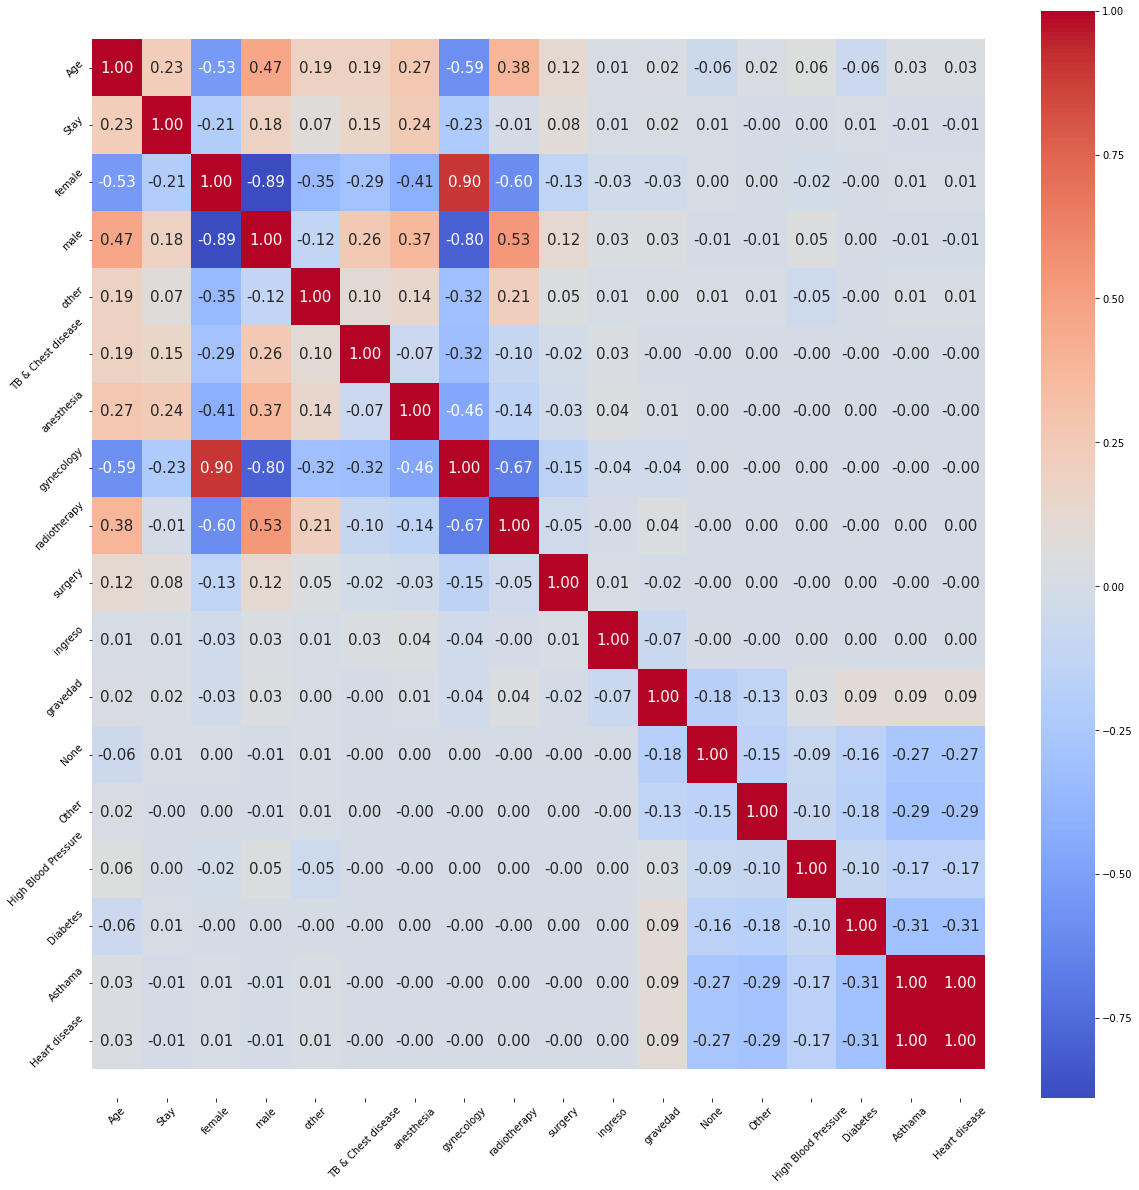

In [116]:
corr = df.corr()
plot_corre_heatmap(corr)

In [125]:
from sklearn.tree import DecisionTreeClassifier

# Creamos un objeto arbol
tree = DecisionTreeClassifier()

In [122]:
X = df[['anesthesia','gynecology', 'female', 'Age']]
y = df['Stay']

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [126]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [127]:
from sklearn.metrics import accuracy_score

# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.6703494721514379
Accuracy sobre conjunto de Test: 0.6705691056910569
